In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
import os
import tensorflow as tf
import numpy as np
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
from keras.layers import Conv2D,MaxPool2D,Dropout,Flatten,Dense,BatchNormalization,GlobalAveragePooling2D
from keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [11]:
train_path = "/content/drive/MyDrive/melanoma_cancer_dataset/train"
valid_path = "/content/drive/MyDrive/melanoma_cancer_dataset/test"

num_train_samples = 9605
num_val_samples = 1000
train_batch_size = 10
val_batch_size = 10
image_size = 224

train_steps = np.ceil(num_train_samples / train_batch_size)
val_steps = np.ceil(num_val_samples / val_batch_size)

In [12]:

Labels = ['Benign', 'Malignant']
print ("class : ")
for i in range(len(Labels)):
    print (i, end = " ")
    print (Labels[i])

class : 
0 Benign
1 Malignant


In [ ]:
# Get the list of subdirectories within the train directory
subdirs = [subdir for subdir in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, subdir))]

# Print the subdirectories and count of images in each subdirectory
for subdir in subdirs:
    subdir_path = os.path.join(train_path, subdir)
    num_images = len(os.listdir(subdir_path))
    print(f"Subdirectory: {subdir}, Number of Images: {num_images}")

Subdirectory: benign, Number of Images: 5000
Subdirectory: malignant, Number of Images: 4605


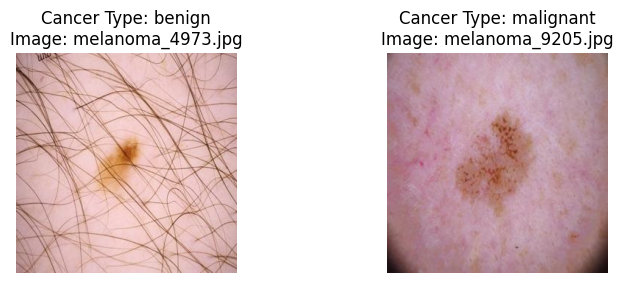

In [ ]:
from PIL import Image
# Create a subplot for each subdirectory
plt.figure(figsize=(15, 10))
for i, subdir in enumerate(subdirs):
    subdir_path = os.path.join(train_path, subdir)
    # Get the list of image files in the subdirectory
    image_files = [file for file in os.listdir(subdir_path) if file.endswith(('.jpg', '.jpeg', '.png', '.gif', '.bmp'))]
    # Select the first image from the subdirectory
    if image_files:
        first_image_path = os.path.join(subdir_path, image_files[0])
        image = Image.open(first_image_path)
        # Plot the image
        plt.subplot(4, 4, i+1)  # Adjust the subplot parameters as needed
        plt.imshow(image)
        plt.title(f"Cancer Type: {subdir}\nImage: {image_files[0]}")
        plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
print('Number of classes:',len(Labels))

Number of classes: 2


In [ ]:
size = []

for dir in os.listdir(train_path):
    files_path = os.path.join(train_path, dir)
    files = os.listdir(files_path)

    for file in files:
        file_path = os.path.join(files_path, file)

        try:
            image = plt.imread(file_path)
            size.append(image.shape)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

# Display counts of different image sizes
pd.Series(size).value_counts()

(300, 300, 3)    9605
Name: count, dtype: int64

In [ ]:

size = []

for dir in os.listdir(valid_path):
    files_path = os.path.join(valid_path, dir)
    files = os.listdir(files_path)

    for file in files:
        file_path = os.path.join(files_path, file)

        try:
            image = plt.imread(file_path)
            size.append(image.shape)
        except FileNotFoundError:
            print(f"File not found: {file_path}")

# Display counts of different image sizes
pd.Series(size).value_counts()

(300, 300, 3)    1000
Name: count, dtype: int64

In [ ]:
number_of_images={}
for dir in os.listdir(train_path):
    number_of_images=len(os.listdir(os.path.join(train_path,dir)))
    print(f'For training data , found {number_of_images} in folder {dir}')

For training data , found 5000 in folder benign
For training data , found 4605 in folder malignant


In [ ]:
number_of_images={}
for dir in os.listdir(valid_path):
    number_of_images=len(os.listdir(os.path.join(valid_path,dir)))
    print(f'For training data , found {number_of_images} in folder {dir}')

For training data , found 500 in folder malignant
For training data , found 500 in folder benign


In [5]:

datagen = ImageDataGenerator(
    preprocessing_function= \
    tf.keras.applications.mobilenet.preprocess_input)

train_batches = datagen.flow_from_directory(train_path,
                                            target_size=(image_size,image_size),
                                            batch_size=train_batch_size)

valid_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=val_batch_size)

# Note: shuffle=False causes the test dataset to not be shuffled
test_batches = datagen.flow_from_directory(valid_path,
                                            target_size=(image_size,image_size),
                                            batch_size=1,
                                            shuffle=False)

Found 9605 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [ ]:

def preprocessingImages1(path):
  """
  input : path
  output :preprocessed images
  """
  image_data=ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.4,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest',

)
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=10,class_mode='binary')
  return image

In [ ]:
train_data=preprocessingImages1(train_path)

Found 9605 images belonging to 2 classes.


In [ ]:
def preprocessingImages2(path):
  """
  input : path
  output :preprocessed images
  """
  image_data=ImageDataGenerator(rescale=1/255,fill_mode='nearest')
  image=image_data.flow_from_directory(directory=path,target_size=(224,224),batch_size=10,class_mode='binary')
  return image

In [ ]:
test_data=preprocessingImages2(valid_path)

Found 1000 images belonging to 2 classes.


In [6]:
def plot_training(hist):
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']
    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    plt.figure(figsize= (20, 8))
    plt.style.use('fivethirtyeight')
    Epochs = [i+1 for i in range(len(tr_acc))]
    loss_label = f'best epoch= {str(index_loss + 1)}'
    acc_label = f'best epoch= {str(index_acc + 1)}'

    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
    plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
    plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout
    plt.show()

In [7]:
#cnn model
model1=Sequential()
model1.add(Conv2D(filters=8,kernel_size=(3,3),activation="relu",input_shape=(224,224,3)))

model1.add(Conv2D(filters=16,kernel_size=(3,3),activation="relu"))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu"))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Dropout(rate=0.25))

model1.add(Flatten())
model1.add(Dense(units=8,activation='relu'))
model1.add(Dense(units=1024,activation='relu'))
model1.add(Dense(units=32,activation='relu'))
model1.add(Dense(units=8,activation='relu'))
model1.add(Dropout(rate=0.25))
model1.add(Dense(units=2,activation='softmax'))

model1.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 8)       224       
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 16)      1168      
                                                                 
 batch_normalization (Batch  (None, 220, 220, 16)      64        
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 16)      0         
 D)                                                              
                                                                 
 conv2d_2 (Conv2D)           (None, 108, 108, 32)      4640      
                                                                 
 batch_normalization_1 (Bat  (None, 108, 108, 32)      1

In [9]:
history = model1.fit_generator(train_batches, steps_per_epoch=train_steps,

                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=15, verbose=1)

Epoch 1/15


<ipython-input-9-7642cdaedb38>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train_batches, steps_per_epoch=train_steps,


961/961 [==============================] - 58s 60ms/step - loss: 0.2578 - accuracy: 0.8971 - val_loss: 0.2457 - val_accuracy: 0.9050
Epoch 2/15
961/961 [==============================] - 55s 57ms/step - loss: 0.2418 - accuracy: 0.9023 - val_loss: 0.2372 - val_accuracy: 0.9000
Epoch 3/15
961/961 [==============================] - 54s 56ms/step - loss: 0.2313 - accuracy: 0.9064 - val_loss: 0.2644 - val_accuracy: 0.9050
Epoch 4/15
961/961 [==============================] - 55s 57ms/step - loss: 0.2170 - accuracy: 0.9100 - val_loss: 0.3138 - val_accuracy: 0.8980
Epoch 5/15
961/961 [==============================] - 52s 54ms/step - loss: 0.2097 - accuracy: 0.9098 - val_loss: 0.3191 - val_accuracy: 0.8880
Epoch 6/15
961/961 [==============================] - 54s 56ms/step - loss: 0.1887 - accuracy: 0.9155 - val_loss: 0.3726 - val_accuracy: 0.9020
Epoch 7/15
961/961 [==============================] - 54s 56ms/step - loss: 0.1674 - accuracy: 0.9252 - val_loss: 0.5165 - val_accuracy: 0.9030
Epo

In [12]:
#cnn model
model1=Sequential()
model1.add(Conv2D(filters=8,kernel_size=(3,3),activation="relu",input_shape=(224,224,3)))

model1.add(Conv2D(filters=16,kernel_size=(3,3),activation="relu"))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Conv2D(filters=32,kernel_size=(3,3),activation="relu"))
model1.add(tf.keras.layers.BatchNormalization())
model1.add(MaxPool2D(pool_size=(2,2)))

model1.add(Dropout(rate=0.25))

model1.add(Flatten())
model1.add(Dense(units=8,activation='relu'))
model1.add(Dense(units=512,activation='relu'))

model1.add(Dense(units=8,activation='relu'))
model1.add(Dropout(rate=0.25))
model1.add(Dense(units=2,activation='softmax'))

model1.compile(optimizer='adam',loss="categorical_crossentropy",metrics=["accuracy"])
model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 222, 222, 8)       224       
                                                                 
 conv2d_7 (Conv2D)           (None, 220, 220, 16)      1168      
                                                                 
 batch_normalization_4 (Bat  (None, 220, 220, 16)      64        
 chNormalization)                                                
                                                                 
 max_pooling2d_4 (MaxPoolin  (None, 110, 110, 16)      0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 108, 108, 32)      4640      
                                                                 
 batch_normalization_5 (Bat  (None, 108, 108, 32)     

In [17]:
history = model1.fit_generator(train_batches, steps_per_epoch=train_steps,

                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=10, verbose=1)

Epoch 1/10
  1/961 [..............................] - ETA: 1:22 - loss: 0.0692 - accuracy: 1.0000

<ipython-input-17-c7e37446188e>:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model1.fit_generator(train_batches, steps_per_epoch=train_steps,


961/961 [==============================] - 52s 55ms/step - loss: 0.0916 - accuracy: 0.9620 - val_loss: 0.8341 - val_accuracy: 0.9000
Epoch 2/10
961/961 [==============================] - 52s 54ms/step - loss: 0.0974 - accuracy: 0.9612 - val_loss: 0.6512 - val_accuracy: 0.9010
Epoch 3/10
961/961 [==============================] - 54s 56ms/step - loss: 0.0895 - accuracy: 0.9631 - val_loss: 0.5883 - val_accuracy: 0.8920
Epoch 4/10
961/961 [==============================] - 53s 55ms/step - loss: 0.0752 - accuracy: 0.9701 - val_loss: 0.6675 - val_accuracy: 0.8980
Epoch 5/10
961/961 [==============================] - 54s 56ms/step - loss: 0.0827 - accuracy: 0.9648 - val_loss: 0.7268 - val_accuracy: 0.8940
Epoch 6/10
961/961 [==============================] - 51s 53ms/step - loss: 0.0740 - accuracy: 0.9685 - val_loss: 0.7904 - val_accuracy: 0.8910
Epoch 7/10
961/961 [==============================] - 53s 56ms/step - loss: 0.0688 - accuracy: 0.9712 - val_loss: 0.7727 - val_accuracy: 0.9060
Epo

In [19]:
prediction1 = model1.predict(test_batches)

1000/1000 [==============================] - 9s 9ms/step


In [20]:
from sklearn.metrics import classification_report
# Extracting true labels
true_labels = test_batches.classes

# Convert predicted probabilities to class labels using the class indices
predicted_labels = np.argmax(prediction1, axis=1)

# Invert the class indices dictionary to get class names from indices
class_names = {v: k for k, v in test_batches.class_indices.items()}

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names.values())
print(report)

              precision    recall  f1-score   support

      benign       0.90      0.90      0.90       500
   malignant       0.90      0.90      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



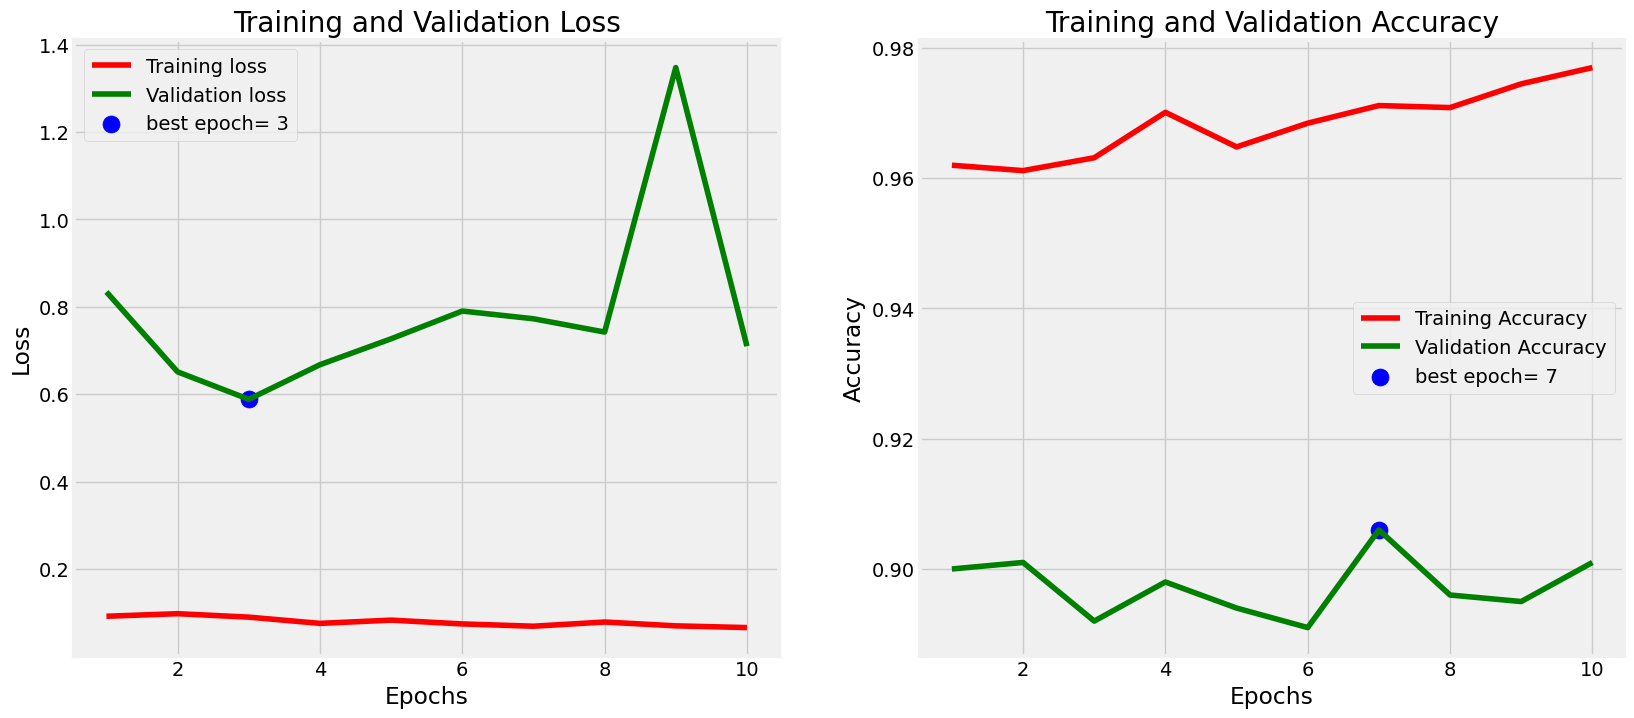

In [21]:
plot_training(history)

In [18]:
model1.save("/content/drive/MyDrive/new_trained.h5")

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
# create a copy of a mobilenet model

mobile = tf.keras.applications.mobilenet.MobileNet()

In [ ]:
mobile.summary()

Model: "mobilenet_1.00_224"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32

In [ ]:
type(mobile.layers)

list

In [ ]:
# How many layers does MobileNet have?
len(mobile.layers)

91

In [ ]:
from keras.layers import Dense, Dropout, Flatten
from keras.metrics import categorical_crossentropy
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Model
from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint


In [ ]:
# CREATE THE MODEL ARCHITECTURE

# Exclude the last 5 layers of the above model.
# This will include all layers up to and including global_average_pooling2d_1
x = mobile.layers[-1].output

# Create a new dense layer for predictions
# Flatten the output layer to 1 dimension
x = Flatten()(x)
# # Create a new dense layer for predictions
# x = Dense(8, activation='relu')(x)
x = Dense(1024, activation='relu')(x)
x = Dense(512, activation='relu')(x)
# 7 corresponds to the number of classes
x = Dropout(0.25)(x)
predictions = Dense(2, activation='softmax')(x)

# inputs=mobile.input selects the input layer, outputs=predictions refers to the
# dense layer we created above.

model = Model(inputs=mobile.input, outputs=predictions)

In [ ]:
model.summary()


Model: "model_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizati  (None, 112, 112, 32)      128       
 on)                                                             
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D  (None, 112, 112, 32)      288       
 )                                                               
                                                                 
 conv_dw_1_bn (BatchNormali  (None, 112, 112, 32)      128

In [ ]:
# Define Top2 and Top3 Accuracy

from keras.metrics import categorical_accuracy, top_k_categorical_accuracy

def top_3_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=3)

def top_2_accuracy(y_true, y_pred):
    return top_k_categorical_accuracy(y_true, y_pred, k=2)

In [ ]:
model.compile(optimizer="adam", loss='categorical_crossentropy',
              metrics=['accuracy'])



In [ ]:
# Get the labels that are associated with each index
print(valid_batches.class_indices)

{'benign': 0, 'malignant': 1}


In [ ]:

# filepath = "/content/drive/MyDrive/model10.h5"





history = model.fit_generator(train_batches, steps_per_epoch=train_steps,

                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=5, verbose=1)


<ipython-input-122-17234cc7caef>:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(train_batches, steps_per_epoch=train_steps,


Epoch 1/5
961/961 [==============================] - 61s 63ms/step - loss: 0.0570 - accuracy: 0.9811 - val_loss: 0.3385 - val_accuracy: 0.9040
Epoch 2/5
961/961 [==============================] - 62s 65ms/step - loss: 0.0546 - accuracy: 0.9821 - val_loss: 0.3450 - val_accuracy: 0.9090
Epoch 3/5
961/961 [==============================] - 61s 63ms/step - loss: 0.0485 - accuracy: 0.9852 - val_loss: 0.3635 - val_accuracy: 0.8960
Epoch 4/5
961/961 [==============================] - 62s 65ms/step - loss: 0.0517 - accuracy: 0.9831 - val_loss: 0.3325 - val_accuracy: 0.8970
Epoch 5/5
961/961 [==============================] - 62s 65ms/step - loss: 0.0432 - accuracy: 0.9875 - val_loss: 0.3339 - val_accuracy: 0.9010


In [ ]:
model.save("/content/drive/MyDrive/trained_mobilenet.h5")

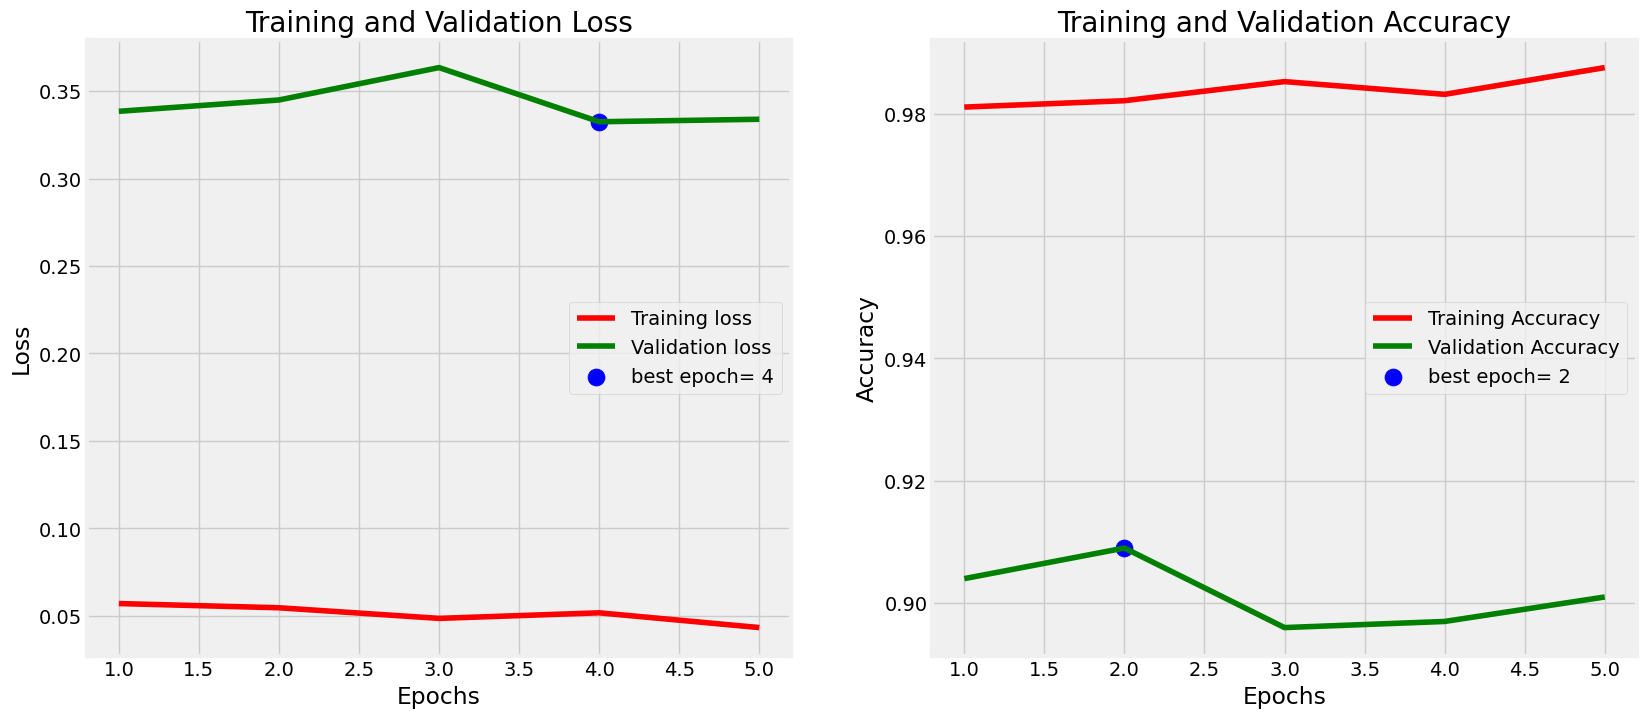

In [ ]:
plot_training(history)

In [ ]:
import tensorflow as tf

# Load the HDF5 model
h5_model_path = '/content/drive/MyDrive/Colab Notebooks/trained_mobilenet.h5'
loaded_model = tf.keras.models.load_model(h5_model_path)

# Convert the HDF5 model to TensorFlow Lite
converter = tf.lite.TFLiteConverter.from_keras_model(loaded_model)
tflite_model = converter.convert()

# Save the converted model to a file
tflite_model_path = '/content/drive/MyDrive/Colab Notebooks/tflite_model.tflite'
with open(tflite_model_path, 'wb') as f:
    f.write(tflite_model)


In [ ]:
from keras.applications import ResNet50
from keras.models import Sequential
from keras.layers import Dense, Flatten

# Load pre-trained ResNet50 model without the top (classification) layer
resnet_base = ResNet50(weights='imagenet',include_top=False,  input_shape=(224, 224, 3))


# Create a new model by adding custom classification layers on top of the ResNet50 base
model2 = Sequential([
    resnet_base,
    Flatten(),
    Dropout(rate=0.3),
    Dense(2, activation='softmax')
])

# Compile the model
model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Print model summary
model2.summary()

94765736/94765736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 7, 7, 2048)        23587712  
                                                                 
 flatten (Flatten)           (None, 100352)            0         
                                                                 
 dropout (Dropout)           (None, 100352)            0         
                                                                 
 dense (Dense)               (None, 2)                 200706    
                                                                 
Total params: 23788418 (90.75 MB)
Trainable params: 23735298 (90.54 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
# Train the model
history2 =model2.fit(
    train_batches, steps_per_epoch=train_steps,

                    validation_data=valid_batches,
                    validation_steps=val_steps,
                    epochs=5,
   )

Epoch 1/5
365/961 [==========>...................] - ETA: 25:10 - loss: 3.3891 - accuracy: 0.7195

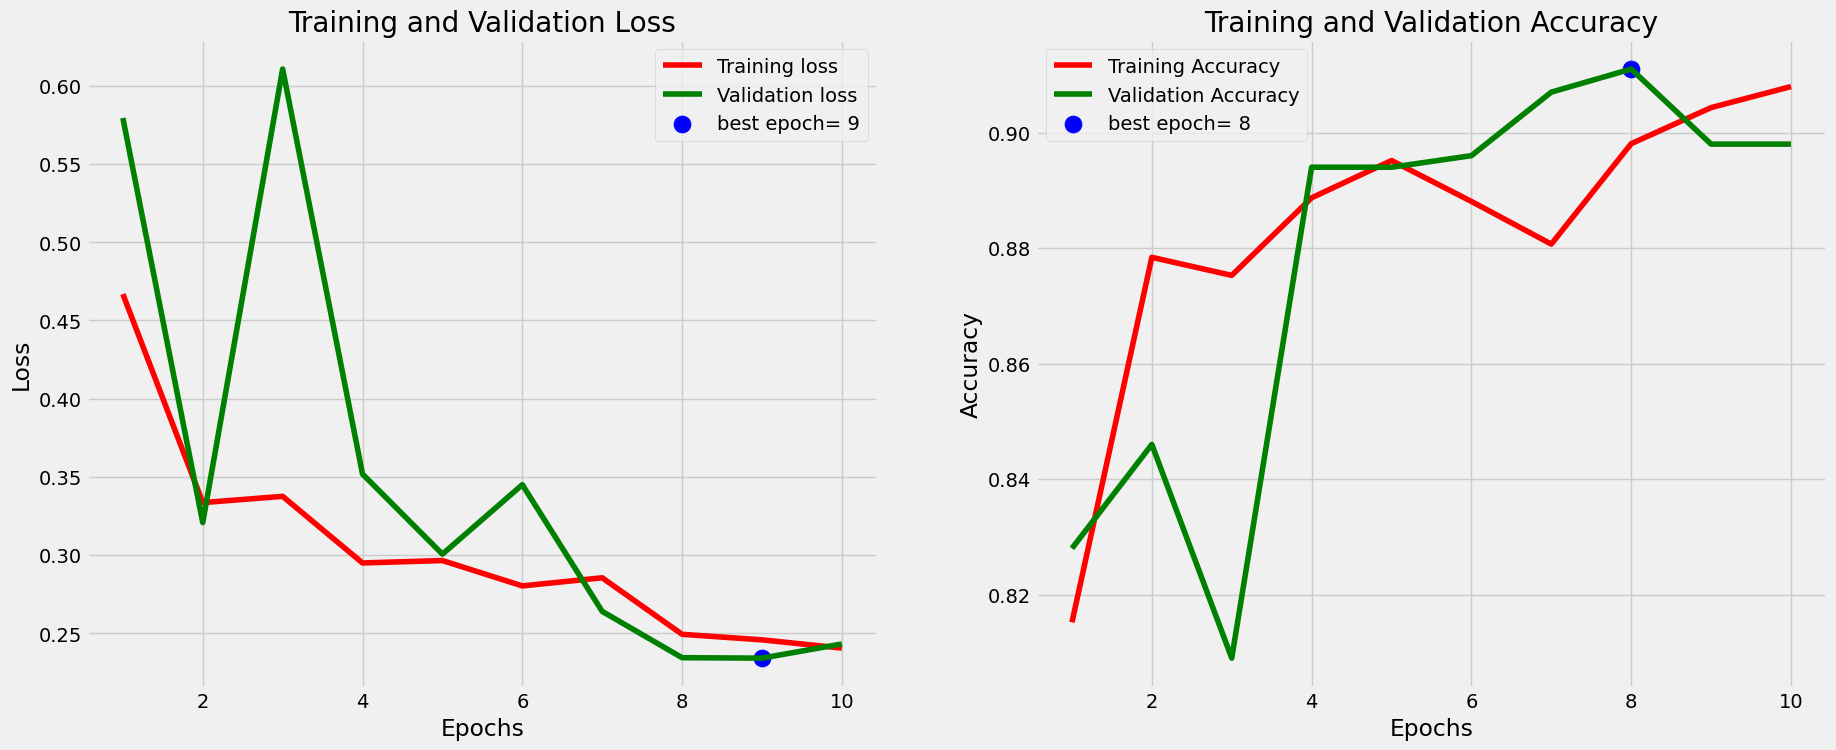

In [ ]:
plot_training(history)

In [ ]:
import keras

In [ ]:
NewModel = keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/trained_mobilenet.h5')

In [ ]:
prediction = NewModel.predict(test_batches)

1000/1000 [==============================] - 414s 412ms/step


In [ ]:
ModelLoss, ModelAccuracy = NewModel.evaluate(test_batches)
print('Model Loss is {}'.format(ModelLoss))
print('Model Accuracy is {}'.format(ModelAccuracy ))

1000/1000 [==============================] - 8s 7ms/step - loss: 0.3339 - accuracy: 0.9010
Model Loss is 0.3339381515979767
Model Accuracy is 0.9010000228881836


In [ ]:
print('Prediction Shape is {}'.format(prediction.shape))

Prediction Shape is (1000, 2)


In [ ]:
print('Prediction items are {}'.format(prediction[550:555]))

Prediction items are [[6.6478809e-05 9.9993348e-01]
 [8.6561218e-03 9.9134386e-01]
 [8.4066320e-05 9.9991596e-01]
 [3.5016943e-05 9.9996495e-01]
 [3.8393082e-05 9.9996161e-01]]


In [ ]:
test_labels = test_batches.classes

In [ ]:
test_labels[550:555]

array([1, 1, 1, 1, 1], dtype=int32)

In [ ]:
# We need these to plot the confusion matrix.
test_labels

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
# Print the label associated with each class
test_batches.class_indices

{'benign': 0, 'malignant': 1}

In [ ]:
len(test_labels), len(prediction)

(1000, 1000)

In [ ]:
prediction


array([[0.96352136, 0.03647855],
       [0.9968347 , 0.00316533],
       [0.99568033, 0.00431959],
       ...,
       [0.24630655, 0.75369346],
       [0.89167666, 0.10832332],
       [0.38077942, 0.61922055]], dtype=float32)

In [ ]:
prediction.shape

(1000, 2)

In [ ]:
np.round(prediction)

array([[1., 0.],
       [1., 0.],
       [1., 0.],
       ...,
       [0., 1.],
       [1., 0.],
       [0., 1.]], dtype=float32)

In [ ]:
from keras.preprocessing.image import load_img
# cancer_types = ['benign','malignant' ]
# Directory containing the images
image_dir = "/content/Untitled Folder"

# Iterate over the first 5 samples
for i in range(495,505):
    # Get the cancer type prediction for the ith sample
    predicted_cancer_index = np.argmax(prediction[i])
    predicted_cancer =Labels[predicted_cancer_index]

    # Get the name of the ith sample from test_batches
    sample_name = test_batches.filenames[i]

    # Load the image
    img_path = image_dir + "/" + sample_name
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
    else:
        img = load_img(img_path, target_size=(224, 224))  # Adjust target_size as per your model

    # Plot the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Sample: {sample_name}\nPredicted Cancer Type: {predicted_cancer}")
    plt.axis('off')
    plt.show()

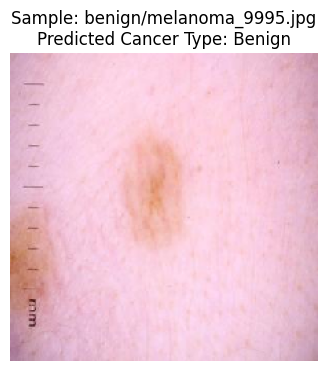

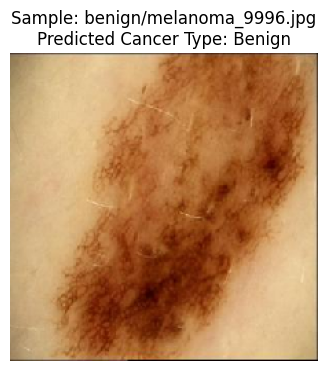

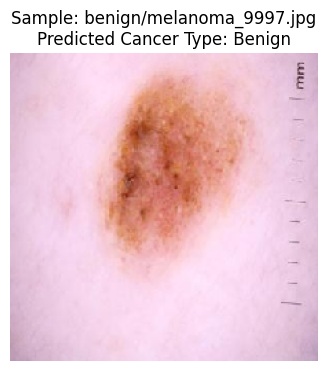

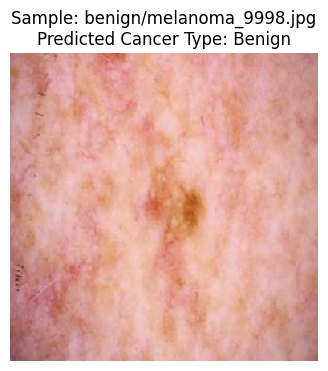

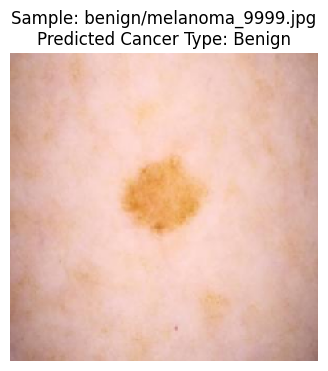

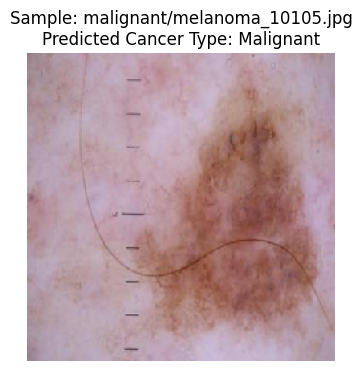

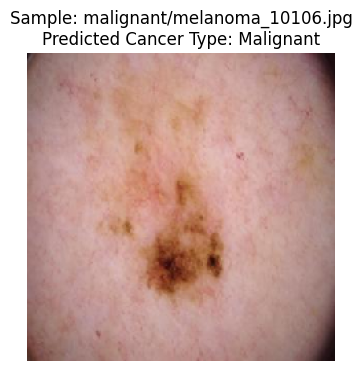

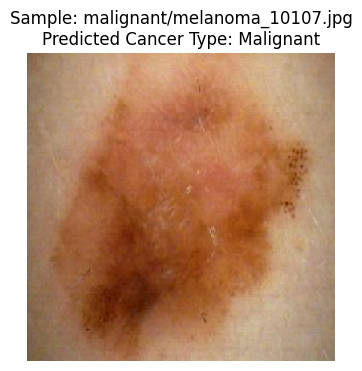

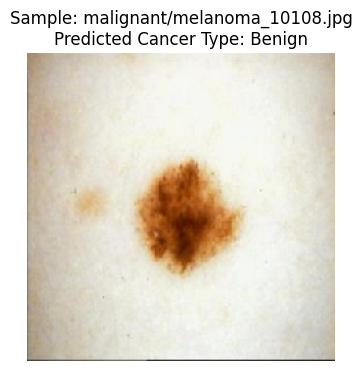

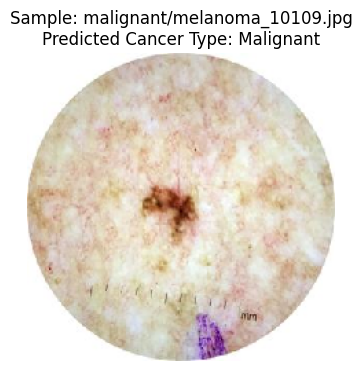

In [ ]:
from keras.preprocessing.image import load_img
# cancer_types = ['benign','malignant' ]
# Directory containing the images
image_dir = "/content/drive/MyDrive/melanoma_cancer_dataset/test"

# Iterate over the first 5 samples
for i in range(495,505):
    # Get the cancer type prediction for the ith sample
    predicted_cancer_index = np.argmax(prediction[i])
    predicted_cancer =Labels[predicted_cancer_index]

    # Get the name of the ith sample from test_batches
    sample_name = test_batches.filenames[i]

    # Load the image
    img_path = image_dir + "/" + sample_name
    if not os.path.exists(img_path):
        print(f"File not found: {img_path}")
    else:
        img = load_img(img_path, target_size=(224, 224))  # Adjust target_size as per your model

    # Plot the image
    plt.figure(figsize=(4, 4))
    plt.imshow(img)
    plt.title(f"Sample: {sample_name}\nPredicted Cancer Type: {predicted_cancer}")
    plt.axis('off')
    plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools

In [ ]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

In [ ]:
test_labels.shape

(1000,)

In [ ]:
# argmax returns the index of the max value in a row
cm = confusion_matrix(test_labels, prediction.argmax(axis=1))

In [ ]:
test_batches.class_indices

{'benign': 0, 'malignant': 1}

Confusion matrix, without normalization
[[449  51]
 [ 48 452]]


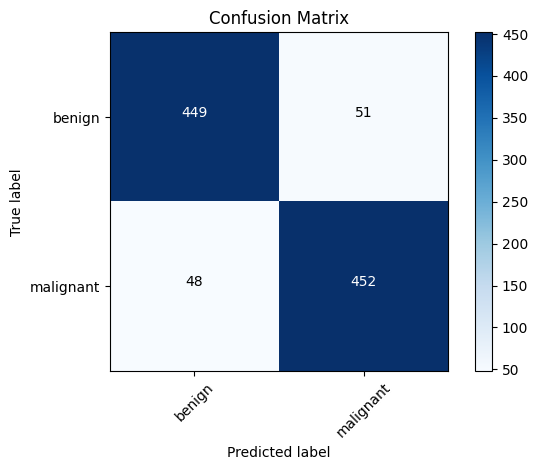

In [ ]:
# Define the labels of the class indices. These need to match the
# order shown above.
cm_plot_labels = ['benign', 'malignant']

plot_confusion_matrix(cm, cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
# Extracting true labels
true_labels = test_batches.classes

# Convert predicted probabilities to class labels using the class indices
predicted_labels = np.argmax(prediction, axis=1)

# Invert the class indices dictionary to get class names from indices
class_names = {v: k for k, v in test_batches.class_indices.items()}

# Generate classification report
report = classification_report(true_labels, predicted_labels, target_names=class_names.values())
print(report)

              precision    recall  f1-score   support

      benign       0.90      0.90      0.90       500
   malignant       0.90      0.90      0.90       500

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

